# **1. Import Libraries and Load Data**





## 1.1 Install Libraries

In [ ]:
!pip install yfinance pandas_datareader pandas numpy PyPortfolioOpt

## 1.2 Fetch Data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch S&P 500 ETF (SPY), Gold ETF (GLD)
tickers = ["SPY", "QQQ", "GLD"]
start_date = "2013-01-01"
end_date = "2023-12-31"

data = yf.download(tickers, start=start_date, end=end_date)

prices = data["Close"]

# print(data.head())
print(prices.head())

[*********************100%***********************]  3 of 3 completed

Ticker             GLD        QQQ         SPY
Date                                         
2013-01-02  163.169998  60.452339  117.624855
2013-01-03  161.199997  60.137470  117.359070
2013-01-04  160.440002  59.939568  117.874466
2013-01-07  159.429993  59.957558  117.552345
2013-01-08  160.559998  59.840622  117.214157


## 1.3 Data Pre-Processing

In [ ]:
returns = prices.asfreq('D').interpolate(method='time')

# **2. Bayesian Optimization with GP-Hedge**

## 2.1 Import libraries and data processing

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

returns = returns[['GLD', 'QQQ', 'SPY']].values

## 2.2 Define Sharpe Ratio

In [ ]:
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate=0.0, annualized=True):
    mean = np.mean(portfolio_returns)
    std = np.std(portfolio_returns)
    if std == 0:
        return 0.0
    if annualized:
        mean *= 252
        std *= np.sqrt(252)
    return (mean - risk_free_rate) / std

## 2.3 Initialize Gaussian Process and Acquisition Functions

In [ ]:
# Gaussian Process with Matern kernel
kernel = Matern(length_scale=[1.0, 1.0], nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

# Acquisition Functions
def expected_improvement(X, gp, current_max, xi=0.01):
    mu, sigma = gp.predict(X.reshape(-1, 2), return_std=True)
    imp = mu - current_max - xi
    Z = imp / (sigma + 1e-9)
    return imp * norm.cdf(Z) + sigma * norm.pdf(Z)

def probability_improvement(X, gp, current_max, xi=0.01):
    mu, sigma = gp.predict(X.reshape(-1, 2), return_std=True)
    Z = (mu - current_max - xi) / (sigma + 1e-9)
    return norm.cdf(Z)

def upper_confidence_bound(X, gp, beta=2.0):
    mu, sigma = gp.predict(X.reshape(-1, 2), return_std=True)
    return mu + beta * sigma

## 2.4 GP-Hedge Algorithm

In [ ]:
# Initialize parameters
acquisition_funcs = [expected_improvement, probability_improvement, upper_confidence_bound]
num_acq = len(acquisition_funcs)
eta = 0.2  # Hedge learning rate
gains = np.zeros(num_acq)  # Cumulative rewards
X_samples, y_samples = [], []  # Observed data

random_seed = 3
np.random.seed(random_seed)

# Initial random samples
for _ in range(10):
    w1 = np.random.uniform(0, 1)
    w2 = np.random.uniform(0, 1 - w1)
    portfolio_returns = returns[:, 0] * w1 + returns[:, 1] * w2 + returns[:, 2] * (1 - w1 - w2)
    sharpe = calculate_sharpe_ratio(portfolio_returns)
    X_samples.append([w1, w2])
    y_samples.append(sharpe)

# Train GP on initial data
X_train = np.array(X_samples)
y_train = np.array(y_samples)
gp.fit(X_train, y_train)


sharpe_history = [np.max(y_train)]

# Optimization loop
n_iterations = 50
for _ in range(n_iterations - 10):
    current_max = np.max(y_train)
    nominees, rewards = [], []

    # Nominate points for each acquisition function
    for acq_func in acquisition_funcs:
        best_sharpe = -np.inf
        best_weights = None
        # Random search for simplicity (replace with L-BFGS for better performance)
        for _ in range(1000):
            w1 = np.random.uniform(0, 1)
            w2 = np.random.uniform(0, 1 - w1)
            x = np.array([w1, w2])
            if acq_func == expected_improvement:
                acq_value = expected_improvement(x, gp, current_max)
            elif acq_func == probability_improvement:
                acq_value = probability_improvement(x, gp, current_max)
            else:
                acq_value = upper_confidence_bound(x, gp)
            if acq_value > best_sharpe:
                best_sharpe = acq_value
                best_weights = x
        nominees.append(best_weights)
        rewards.append(gp.predict([best_weights])[0])  # Reward = GP mean

    # Hedge selection
    probabilities = np.exp(eta * gains) / np.sum(np.exp(eta * gains))
    selected = np.random.choice(num_acq, p=probabilities)
    w1, w2 = nominees[selected]
    w3 = 1 - w1 - w2

    # Evaluate and update
    portfolio_returns = returns[:, 0] * w1 + returns[:, 1] * w2 + returns[:, 2] * w3
    sharpe = calculate_sharpe_ratio(portfolio_returns)
    sharpe_history.append(sharpe)
    X_train = np.vstack((X_train, [w1, w2]))
    y_train = np.append(y_train, sharpe)
    gains += rewards  # Update cumulative gains

    # Retrain GP
    gp.fit(X_train, y_train)

# Extract optimal weights
best_idx = np.argmax(y_train)
best_w1, best_w2 = X_train[best_idx]
best_w3 = 1 - best_w1 - best_w2

print(f"Optimal Weights:")
print(f"GLD: {best_w1:.4f}, QQQ: {best_w2:.4f}, SPY: {best_w3:.4f}")
print(f"Max Sharpe Ratio: {y_train[best_idx]:.4f}")

Optimal Weights:
GLD: 0.9999, QQQ: 0.0000, SPY: 0.0000
Max Sharpe Ratio: 87.5158


# **3. Backtesting with Baseline Models**

## 3.1 Implement Baseline Models


In [ ]:
import matplotlib.pyplot as plt

# Define common parameters
n_iterations = 50
risk_free_rate = 0.0

# Initialize results storage
results = {
    "GP-Hedge": [],
    "Random Search": [],
    "BO-EI": [],
    "BO-UCB": [],
    "BO-PI": []
}

# Common data for all models
def evaluate_weights(w1, w2):
    w3 = 1 - w1 - w2
    portfolio_returns = returns[:, 0] * w1 + returns[:, 1] * w2 + returns[:, 2] * w3
    return calculate_sharpe_ratio(portfolio_returns, risk_free_rate)

## 3.2 Random Search Baseline

In [ ]:
# Random Search
best_sharpe_rs = -np.inf
sharpe_history_rs = []
for _ in range(n_iterations):
    w1 = np.random.uniform(0, 1)
    w2 = np.random.uniform(0, 1 - w1)
    sharpe = evaluate_weights(w1, w2)
    if sharpe > best_sharpe_rs:
        best_sharpe_rs = sharpe
    sharpe_history_rs.append(best_sharpe_rs)
results["Random Search"] = sharpe_history_rs

## 3.3 Standard BO with EI/UCB/PI

In [ ]:
def run_bo(acquisition_func, n_init=10):
    X_train, y_train = [], []
    # Initial random samples
    for _ in range(n_init):
        w1 = np.random.uniform(0, 1)
        w2 = np.random.uniform(0, 1 - w1)
        X_train.append([w1, w2])
        y_train.append(evaluate_weights(w1, w2))
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-6)
    gp.fit(X_train, y_train)

    sharpe_history = [np.max(y_train)]
    for _ in range(n_iterations - n_init):
        current_max = np.max(y_train)
        best_sharpe = -np.inf
        best_weights = None
        # Random search for next point
        for _ in range(1000):
            w1 = np.random.uniform(0, 1)
            w2 = np.random.uniform(0, 1 - w1)
            x = np.array([w1, w2])
            if acquisition_func == "EI":
                acq_value = expected_improvement(x, gp, current_max)
            elif acquisition_func == "UCB":
                acq_value = upper_confidence_bound(x, gp, beta=2.0)
            elif acquisition_func == "PI":
                acq_value = probability_improvement(x, gp, current_max)
            if acq_value > best_sharpe:
                best_sharpe = acq_value
                best_weights = x
        # Update
        w1, w2 = best_weights
        sharpe = evaluate_weights(w1, w2)
        X_train = np.vstack((X_train, best_weights))
        y_train = np.append(y_train, sharpe)
        sharpe_history.append(np.max(y_train))
        gp.fit(X_train, y_train)
    return sharpe_history

# Run BO variants
results["BO-EI"] = run_bo("EI")
results["BO-UCB"] = run_bo("UCB")
results["BO-PI"] = run_bo("PI")

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

## 3.4 GP-Hedge Results

In [ ]:
results["GP-Hedge"] = sharpe_history

## 3.5 Plot-Convergence

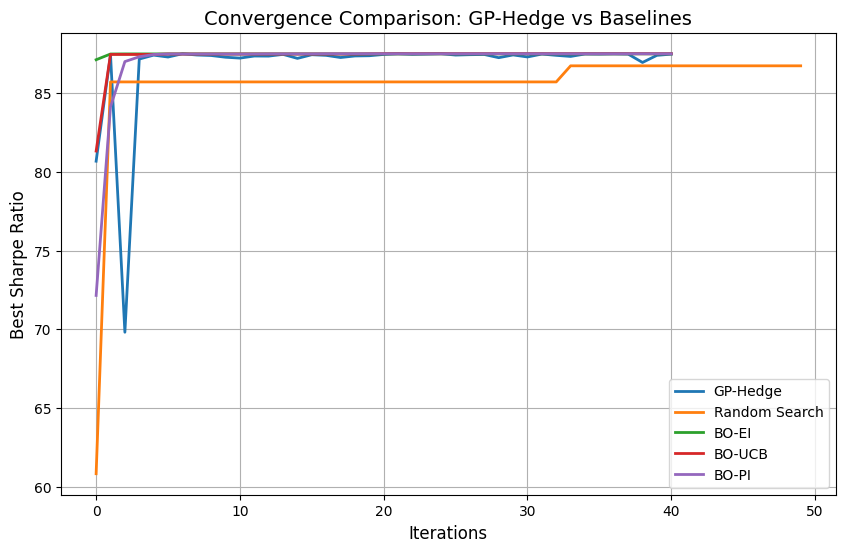

In [ ]:
plt.figure(figsize=(10, 6))
for model in results:
    plt.plot(results[model], label=model, lw=2)

plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Best Sharpe Ratio", fontsize=12)
plt.title("Convergence Comparison: GP-Hedge vs Baselines", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 4. Store Sharpe_History and Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

sharpe_results_gp_hedge = sharpe_history

# Save it to a file in your Drive
save_path = '/content/drive/MyDrive/gp_hedge.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(sharpe_results_gp_hedge, f)

save_path = '/content/drive/MyDrive/weights.pkl'
best_weights = [best_w1, best_w2, best_w3]
with open(save_path, 'wb') as f:
    pickle.dump(best_weights, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
